In [1]:
import findspark
findspark.init()

In [2]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
   
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

In [3]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


In [4]:
raw_data_files = ['/home/spark/files/access_log1', '/home/spark/files/access_log2']
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [5]:
type(base_df)
base_df.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2001:6d8:10:4400:451:aebb:715b:b6df - - [10/Nov/2019:03:44:13 +0100] "GET /wpad.dat HTTP/1.1" 304 - "-" "-"                                                                                                                          |
|2001:6d8:10:4400::1:100b - - [10/Nov/2019:03:44:13 +0100] "GET /wpad.da

In [6]:
base_df_rdd = base_df.rdd
type(base_df_rdd)
base_df_rdd.take(5)

[Row(value='2001:6d8:10:4400:451:aebb:715b:b6df - - [10/Nov/2019:03:44:13 +0100] "GET /wpad.dat HTTP/1.1" 304 - "-" "-"'),
 Row(value='2001:6d8:10:4400::1:100b - - [10/Nov/2019:03:44:13 +0100] "GET /wpad.dat HTTP/1.1" 200 137 "-" "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) ReaderServices/19.12.20036 Chrome/80.0.0.0 Safari/537.36"'),
 Row(value='172.30.254.52 - - [10/Nov/2019:03:44:15 +0100] "GET /wpad.dat HTTP/1.1" 200 137 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) ReaderServices/19.12.20036 Chrome/80.0.0.0 Safari/537.36"'),
 Row(value='2001:6d8:10:4400::1:100b - - [10/Nov/2019:03:44:21 +0100] "GET /wpad.dat HTTP/1.1" 200 137 "-" "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) ReaderServices/19.12.20036 Chrome/80.0.0.0 Safari/537.36"'),
 Row(value='172.30.254.52 - - [10/Nov/2019:03:44:23 +0100] "GET /wpad.dat HTTP/1.1" 200 137 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (K

In [7]:
from pyspark.sql.functions import regexp_extract

log_df = base_df.select(regexp_extract('value', r'(^[\S+]+) -', 1).alias('host'),
                          regexp_extract('value', r'(^[\S+]+) - - \[(.*)\]', 2).alias('timestamp'),
                          regexp_extract('value', r'(^[\S+]+) - - \[(.*)\] "(\w+)', 3).alias('method'),
                          regexp_extract('value', r'(^[\S+]+) - - \[(.*)\] "(\w+) (.*?) (.*?)', 4).alias('endpoint'),
                          regexp_extract('value', r'(^[\S+]+) - - \[(.*) \+(.*)\] "(\w+) (.*?) (.*?)" ', 6).alias('protocol'),
                          regexp_extract('value', r'(^[\S+]+) - - \[(.*) \+(.*)\] "(\w+) (.*?) (.*?)" (\d+) ', 7).cast('integer').alias('status'),
                          regexp_extract('value', r'(^[\S+]+) - - \[(.*) \+(.*)\] "(\w+) (.*?) (.*?)" (\d+) (\d+)', 8).cast('integer').alias('content_size'))
log_df.show(10, truncate=True)
print((log_df.count(), len(log_df.columns)))

+--------------------+--------------------+------+---------+--------+------+------------+
|                host|           timestamp|method| endpoint|protocol|status|content_size|
+--------------------+--------------------+------+---------+--------+------+------------+
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   304|        null|
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   200|         137|
|       172.30.254.52|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   200|         137|
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   200|         137|
|       172.30.254.52|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   200|         137|
|2001:6d8:10:4401:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   304|        null|
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   200|         137|
|       172.30.254.52|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   200|         137|
|2001:6d8:

In [8]:
(log_df
    .filter(log_df['content_size']
                .isNull())
    .count())

175714

In [9]:
bad_rows_df = log_df.filter(log_df['host'].isNull()|
                            log_df['timestamp'].isNull() |
                            log_df['method'].isNull() |
                            log_df['endpoint'].isNull() |
                            log_df['status'].isNull() |
                            log_df['content_size'].isNull()|
                            log_df['protocol'].isNull())
bad_rows_df.count()

175714

In [10]:
bad_rows_df.show(5)

+--------------------+--------------------+------+---------+--------+------+------------+
|                host|           timestamp|method| endpoint|protocol|status|content_size|
+--------------------+--------------------+------+---------+--------+------+------------+
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   304|        null|
|2001:6d8:10:4401:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   304|        null|
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   304|        null|
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   304|        null|
|2001:6d8:10:4400:...|10/Nov/2019:03:44...|   GET|/wpad.dat|HTTP/1.1|   304|        null|
+--------------------+--------------------+------+---------+--------+------+------------+
only showing top 5 rows



In [11]:
log_df = log_df.na.fill({'content_size': 0})
log_df.count()

285061

In [12]:
log_df1 = log_df[~log_df['timestamp'].isin([''])]
log_df1.count()

283386

In [13]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [14]:
udf_parse_time = udf(parse_clf_time)

log_dfn = (log_df1.select('*', udf_parse_time(log_df1['timestamp'])
                                   .cast('timestamp')
                                   .alias('time'))
                                   .drop('timestamp'))

In [15]:
log_dfn.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [16]:
log_dfn.createOrReplaceTempView("logs")

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [18]:
def bar_plot_list_of_tuples_horizontal(input_list,x_label,y_label,plot_title):
    y_labels = [val[0] for val in input_list]
    x_labels = [val[1] for val in input_list]
    plt.figure(figsize=(12, 6))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    ax = pd.Series(x_labels).plot(kind='barh')
    ax.set_yticklabels(y_labels)
    for i, v in enumerate(x_labels):
        ax.text(int(v) + 0.5, i - 0.25, str(v),ha='center', va='bottom')

In [19]:
topEndpointsMaxSize = (sqlContext
                .sql("SELECT endpoint,content_size/1024 FROM logs ORDER BY content_size DESC LIMIT 10")
                .rdd.map(lambda row: (row[0], row[1]))
                .collect())

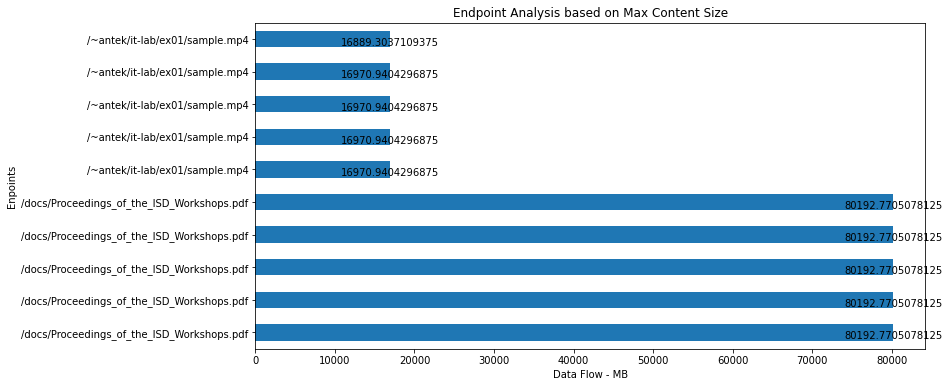

In [20]:
bar_plot_list_of_tuples_horizontal(topEndpointsMaxSize,'Data Flow - MB','Enpoints','Endpoint Analysis based on Max Content Size')

In [21]:
frequentIpAddressesHits = (sqlContext
               .sql("SELECT host, COUNT(*) AS total FROM logs GROUP BY host HAVING total > 1000")
               .rdd.map(lambda row: (row[0], row[1]))
               .collect()) 

In [22]:
import pyspark.sql.functions as F
host_day_df = log_dfn.select(log_dfn.host,
                             F.dayofmonth('time').alias('day'))

In [23]:
status_freq_df = (log_dfn
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
print('Total distinct HTTP Status Codes:', status_freq_df.count()) 

Total distinct HTTP Status Codes: 10


In [24]:
log_freq_df = status_freq_df.withColumn('log(count)',
                                        F.log(status_freq_df['count']))
log_freq_df.show()

+------+------+------------------+
|status| count|        log(count)|
+------+------+------------------+
|  null|   393| 5.973809611869261|
|   200|108149|11.591265184921443|
|   206|    65| 4.174387269895637|
|   301|    52|3.9512437185814275|
|   302|    33|3.4965075614664802|
|   304|172698|12.059299683291801|
|   400|     1|               0.0|
|   401|   508| 6.230481447578482|
|   403|    37|3.6109179126442243|
|   404|  1450|  7.27931883541462|
+------+------+------------------+



In [25]:
host_day_df.show(5, truncate=False)

+-----------------------------------+---+
|host                               |day|
+-----------------------------------+---+
|2001:6d8:10:4400:451:aebb:715b:b6df|10 |
|2001:6d8:10:4400::1:100b           |10 |
|172.30.254.52                      |10 |
|2001:6d8:10:4400::1:100b           |10 |
|172.30.254.52                      |10 |
+-----------------------------------+---+
only showing top 5 rows



In [26]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

In [27]:
daily_hosts_df.show(10, truncate=True)

+---+-----+
|day|count|
+---+-----+
| 10|40070|
| 11|44879|
| 13|22531|
| 14|35302|
| 15|34202|
| 16|37332|
| 17|34789|
| 18|20355|
| 19|10480|
| 20| 3446|
+---+-----+



In [28]:
daily_hosts_pd_df = (daily_hosts_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))

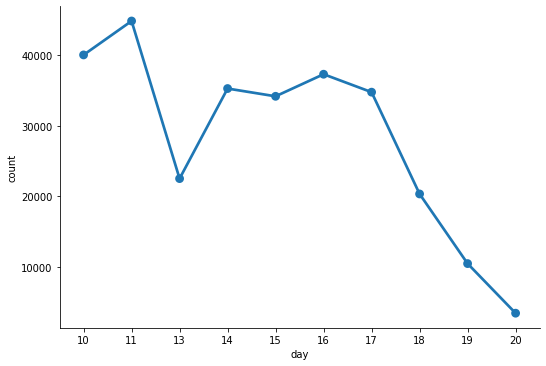

In [29]:
c = sns.catplot(x='day', y='count',
                data=daily_hosts_pd_df,
                kind='point', height=5,
                aspect=1.5)

In [30]:
import findspark
findspark.init()

In [31]:
from pyspark.sql import SparkSession    
spark = SparkSession \
        .builder \
        .appName("Python Spark Data Exploration") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [32]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import random

%matplotlib inline

#set ggplot style
plt.style.use('ggplot')

In [33]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("/home/spark/files/2008.csv",header=True);

In [34]:
df.columns

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [35]:
df.groupBy("UniqueCarrier").count().show()

+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           UA| 449515|
|           AA| 604885|
|           NW| 347652|
|           EV| 280575|
|           B6| 196091|
|           DL| 451931|
|           OO| 567159|
|           F9|  95762|
|           YV| 254930|
|           US| 453589|
|           AQ|   7800|
|           MQ| 490693|
|           OH| 197607|
|           HA|  61826|
|           XE| 374510|
|           AS| 151102|
|           FL| 261684|
|           CO| 298455|
|           WN|1201754|
|           9E| 262208|
+-------------+-------+



In [36]:
df.cache

<bound method DataFrame.cache of DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]>

In [37]:
df.createOrReplaceTempView("flights")

In [38]:
spark.catalog.cacheTable("flights")

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [40]:
import pyspark.sql.functions as F
crshour = df.select('DepDelay', F.round(F.col('CRSDepTime')/100).cast('integer').alias('CRSDepHour'))

In [41]:
crshour.show()

+--------+----------+
|DepDelay|CRSDepHour|
+--------+----------+
|       8|        20|
|      19|         7|
|       8|         6|
|      -4|         9|
|      34|        18|
|      25|        19|
|      67|        18|
|      -1|        10|
|       2|         6|
|       0|        16|
|       6|         7|
|      94|        15|
|      -4|        14|
|       0|         7|
|       2|        17|
|       9|        10|
|      27|        14|
|       9|         7|
|      28|        13|
|      51|        13|
+--------+----------+
only showing top 20 rows



In [42]:
crshour_count = ( crshour.filter(df.DepDelay > 20).groupBy('crsdephour').count().sort('crsdephour').cache())

In [43]:
crshour_count_pd = ( crshour_count.toPandas().sort_values(by=['crsdephour']))

In [44]:
crshour_count_pd

,crsdephour,count
0,0,798
1,1,558
2,2,125
3,3,106
4,4,88
...,...,...
20,20,72519
21,21,58941
22,22,18554
23,23,5861


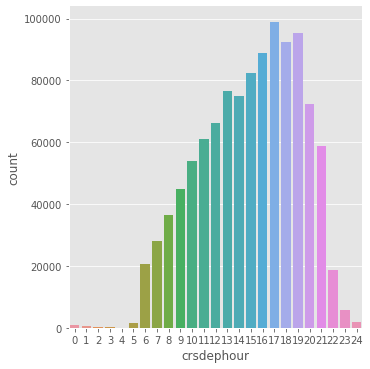

In [45]:
sns.catplot(x='crsdephour', y='count', data=crshour_count_pd,kind='bar',order=crshour_count_pd['crsdephour'] )

In [46]:
from pyspark.sql.functions import col
df.filter(df.DepDelay > 40).groupBy("Dest").count().orderBy(col("count").desc()).show(10)

+----+-----+
|Dest|count|
+----+-----+
| ORD|49602|
| ATL|35715|
| EWR|27951|
| DFW|22963|
| SFO|19658|
| DEN|18294|
| LAX|16799|
| LGA|15978|
| JFK|14827|
| LAS|14351|
+----+-----+
only showing top 10 rows



In [47]:
df.select(df.UniqueCarrier, df.Origin, df.Dest, df.DepDelay, df.CRSDepTime).filter(df.DepDelay > 40).orderBy(col("DepDelay").desc()).show(5)

+-------------+------+----+--------+----------+
|UniqueCarrier|Origin|Dest|DepDelay|CRSDepTime|
+-------------+------+----+--------+----------+
|           NW|   LAX| MSP|     999|       810|
|           AA|   BDL| DFW|     998|      1325|
|           NW|   MEM| MSP|     997|      1345|
|           NW|   DTW| CMH|     996|      1523|
|           MQ|   DCA| LGA|     996|      1400|
+-------------+------+----+--------+----------+
only showing top 5 rows



In [48]:
from pyspark.sql.functions import avg
df.select(df.UniqueCarrier, df.DepDelay).groupBy("UniqueCarrier").agg(avg("DepDelay")).show()

+-------------+-------------------+
|UniqueCarrier|      avg(DepDelay)|
+-------------+-------------------+
|           UA|  14.11257661236138|
|           AA| 13.280898264437912|
|           NW|  6.463235656670833|
|           EV| 11.922537970871462|
|           B6| 12.653395748122113|
|           DL|  8.007765572702564|
|           OO| 7.4564427592619955|
|           F9|  5.919601516833923|
|           YV| 12.000675279875033|
|           US|  5.717489671893907|
|           AQ|-1.3977829337458108|
|           MQ| 10.695641776641581|
|           OH| 11.536153117856601|
|           HA| 0.4552013450206487|
|           XE| 11.395866476493499|
|           AS|  6.848722010417226|
|           FL|  9.262713040260852|
|           CO|  13.18522978602152|
|           WN| 10.383034750411133|
|           9E|  6.765859659983622|
+-------------+-------------------+



In [49]:
tab1 = df.filter(df.DepDelay > 40).groupBy("UniqueCarrier").count().cache()
d1 = (tab1.toPandas().sort_values(by=['count'], ascending=False))
d1

,UniqueCarrier,count
18,WN,97761
1,AA,71041
0,UA,56312
11,MQ,49203
6,OO,47291
...,...,...
19,9E,19345
15,AS,11031
7,F9,4881
13,HA,1393


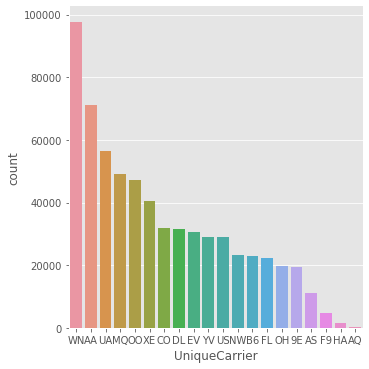

In [50]:
sns.catplot(x='UniqueCarrier', y='count', data=d1,kind='bar',order=d1['UniqueCarrier'] )

In [51]:
tab2 = df.filter(df.DepDelay > 20).groupBy("DayOfWeek").count().orderBy(col("DayOfWeek").asc()).cache()
d2 = (tab2.toPandas())
d2

,DayOfWeek,count
0,1,162834
1,2,147174
2,3,144570
3,4,159197
4,5,185572
5,6,120555
6,7,162469


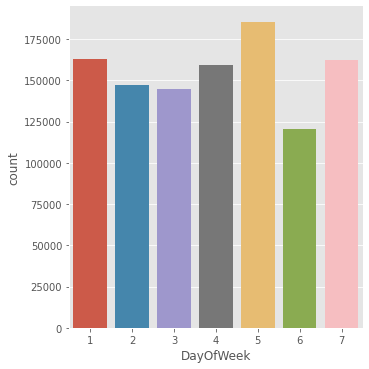

In [52]:
sns.catplot(x='DayOfWeek', y='count', data=d2,kind='bar',order=d2['DayOfWeek'] )